# 이미지 증강(Image Augmentation)
---

### tensorflow
- 텐서플로우 최신 버전 설치

In [ ]:
# !pip install tensorflow==2.11.0

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.11.0


### 필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.get_logger().setLevel('ERROR')

### 데이터 준비
- flower_photos dataset

In [1]:
# !wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

In [ ]:
# !tar -xvzf flower_photos.tgz

In [ ]:
import pathlib

data_dir = pathlib.Path('flower_photos')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [ ]:
import os

flower_list = os.listdir('flower_photos')
for col in flower_list:
    print(col, len(list(data_dir.glob(f'{col}/*.jpg'))))

roses 641
tulips 799
daisy 633
LICENSE.txt 0
dandelion 898
sunflowers 699


In [ ]:
fnames = list(data_dir.glob('roses/*.jpg'))
fnames[0]

PosixPath('flower_photos/roses/20409866779_ac473f55e0_m.jpg')

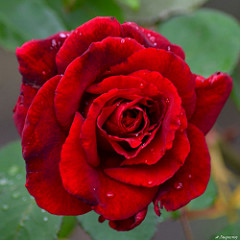

In [ ]:
import PIL
import PIL.Image

PIL.Image.open(fnames[0])

**dataset 객체**
- 클래스: 5개
- 전체: 3670개 (training: 2936개, validation: 734개)

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset='training', 
    image_size=image_size, 
    batch_size=batch_size, 
    seed=42
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset='validation', 
    image_size=image_size, 
    batch_size=batch_size, 
    seed=42
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

- 시각화

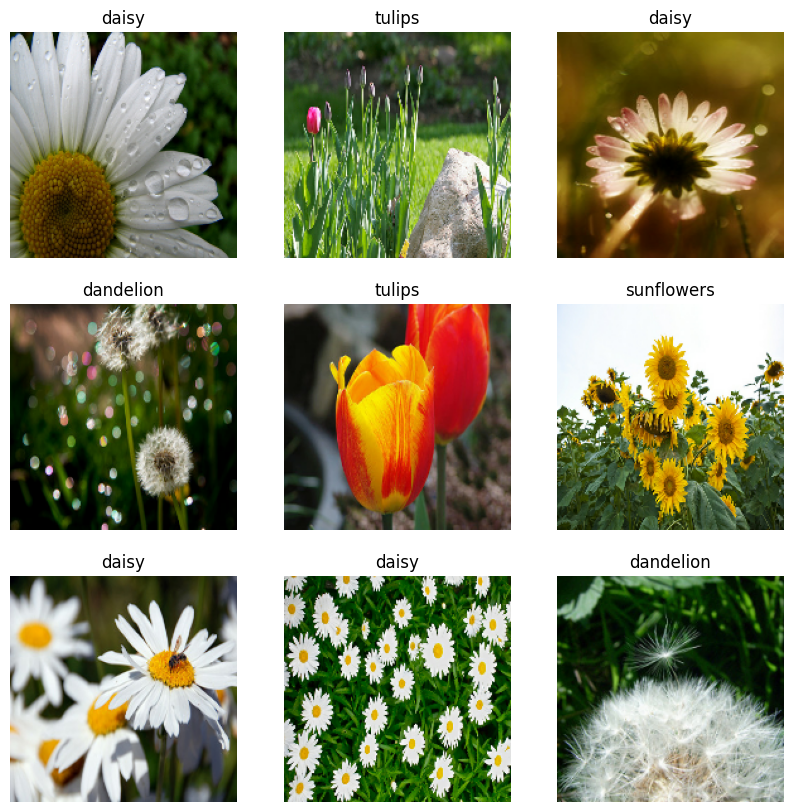

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('int'))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')
plt.show()

**성능을 위한 설정**

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

**이미지 증강**

In [ ]:
data_augmen = keras.Sequential([
    layers.RandomFlip('horizontal'), 
    layers.RandomFlip('vertical'), 
    layers.RandomRotation(0.5)
])

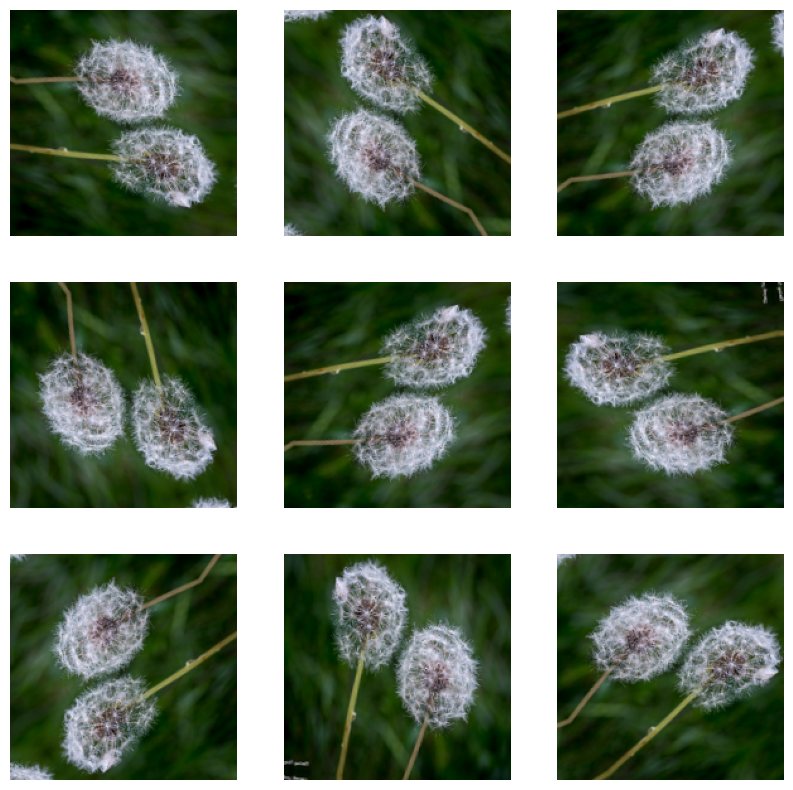

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmen(images)
        plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('int'))
        plt.axis('off')
plt.show()

In [ ]:
# 이미지 증강
data_augmen = keras.Sequential([
    layers.Rescaling(1./255.), 
    layers.Resizing(180, 180), 
    layers.RandomFlip('horizontal'), 
    layers.RandomFlip('vertical'), 
    layers.RandomRotation(0.5)
])

train_ds = train_ds.map(
    lambda img, label: (data_augmen(img), label), 
    num_parallel_calls = tf.data.AUTOTUNE
)

val_ds = val_ds.map(
    lambda img, label: (data_augmen(img), label), 
    num_parallel_calls = tf.data.AUTOTUNE
)

### 모델링(Modeling)

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(180, 180, 3)), 
        layers.MaxPool2D(2), 
        layers.Conv2D(64, 3, activation='relu'), 
        layers.MaxPool2D(2), 
        layers.Flatten(), 
        layers.Dense(256, activation='relu'), 
        layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy', 
        metrics=['acc']
    )

    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 118336)            0         
                                                                 
 dense (Dense)               (None, 256)              

### 학습(Training)

In [ ]:
EPOCHS = 10

history = model.fit(train_ds, 
                    epochs=EPOCHS, 
                    validation_data=val_ds, 
                    verbose=1)

Epoch 1/10
92/92 [==============================] - 265s 3s/step - loss: 1.8769 - acc: 0.3082 - val_loss: 1.3667 - val_acc: 0.4074
Epoch 2/10
92/92 [==============================] - 251s 3s/step - loss: 1.2279 - acc: 0.5007 - val_loss: 1.2542 - val_acc: 0.4959
Epoch 3/10
92/92 [==============================] - 250s 3s/step - loss: 1.0636 - acc: 0.5787 - val_loss: 1.2348 - val_acc: 0.5395
Epoch 4/10
92/92 [==============================] - 263s 3s/step - loss: 0.9993 - acc: 0.6025 - val_loss: 1.1195 - val_acc: 0.5886
Epoch 5/10
92/92 [==============================] - 256s 3s/step - loss: 0.9338 - acc: 0.6257 - val_loss: 1.0586 - val_acc: 0.6185
Epoch 6/10
92/92 [==============================] - 263s 3s/step - loss: 0.8906 - acc: 0.6451 - val_loss: 0.9748 - val_acc: 0.6294
Epoch 7/10
92/92 [==============================] - 260s 3s/step - loss: 0.8705 - acc: 0.6611 - val_loss: 0.9482 - val_acc: 0.6213
Epoch 8/10
92/92 [==============================] - 264s 3s/step - loss: 0.8315 - a